# Analyze the run production (targets, compounds) of the cutoff run

# Some Setup
Define imports, some necessary variables, and some functions

## Imports

In [1]:
from collections import Counter
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymongo
import numpy as np

## Database definitions

In [2]:
# mongo_uri = open("../mongo_uri.csv").read().strip("\n")
client = pymongo.MongoClient()
db_names = [f"kms_YMDB_cutoff_0,{i}t" for i in [2, 4, 6, 8]] + ["kms_YMDB_cutoff_0t"]

## Function to analyze definitions

In [3]:
def get_found_dict(db, max_gens):
    targets = set("C" + i["_id"][1:] for i in client[db].target_compounds.find({}, {"_id": 1}))

    found_dicts = []
    for gen in range(1, max_gens+1):
        found_dict = dict()
        gen_compounds = set(i["_id"] for i in client[db].compounds.find({"Generation": {"$eq": gen}}, {"_id": 1}))
        found_targets = len(gen_compounds.intersection(targets))
        found_dict["targets"] = found_targets
        found_dict["generation"] = gen
        
        if "," not in db.split("_")[-1]:
            found_dict["run"] = db[0:-1] + ".0t"
        else:
            found_dict["run"] = db.replace(",", ".")
        found_dict["tani"] = found_dict["run"].replace(",", ".").split("_")[-1][0:-1]
        found_dict["num"] = float(found_dict["tani"])

        found_dicts.append(found_dict)
        
    return found_dicts

# Manually input run info

In [4]:
# Manually retrieve total compounds generation
compound_gen_dict = {
    "kms_YMDB_cutoff_0.0t":
    {
        "0": 705,
        "1": 148704,
        "2": 0,
        "3": 0
    },
    "kms_YMDB_cutoff_0.2t":
    {
        "0": 705,
        "1": 125496,
        "2": 17168635,
        "3": 0
    },
    "kms_YMDB_cutoff_0.4t":
    {
        "0": 705,
        "1": 67397,
        "2": 5973652,
        "3": 0
    },
    "kms_YMDB_cutoff_0.6t":
    {
        "0": 705,
        "1": 33808,
        "2": 1497405,
        "3": 0
    },
    "kms_YMDB_cutoff_0.8t":
    {
        "0": 705,
        "1": 11648,
        "2": 192994,
        "3": 2450465
    }
   
}

runtime_dict = {
    "kms_YMDB_cutoff_0.0t": {
        "1": 293,
        "2": 0,
        "3": 0
    },
    "kms_YMDB_cutoff_0.2t": {
        "1": 92,
        "2": 289004,
        "3": 0
    },
    "kms_YMDB_cutoff_0.4t": {
        "1": 34,
        "2": 28141,
        "3": 0
    },
    "kms_YMDB_cutoff_0.6t": {
        "1": 18,
        "2": 1901,
        "3": 0
    },
    "kms_YMDB_cutoff_0.8t": {
        "1": 9,
        "2": 108,
        "3": 6560,
    }
}

---
---

# Process Data into dataframe

In [5]:
dict_list = []
n_gen = 3

# Grab data from MongoDB
for i, db in enumerate(db_names):
    dict_list.extend(get_found_dict(db, n_gen))

# Grab manually inserted data
for key, val in compound_gen_dict.items():
    for dict_entry in dict_list:
        if dict_entry["run"] == key:
            gen = dict_entry["generation"]

            dict_entry["compounds"] = val[str(gen)]

for key, val in runtime_dict.items():
    for dict_entry in dict_list:
        if dict_entry["run"] == key:
            gen = dict_entry["generation"]
            
            dict_entry["runtime"] = val[str(gen)]
    

# Make df from the data
tani_df = pd.DataFrame(dict_list)
runs = [r for r in set(tani_df["run"])]

# Grab total values
for run in runs:
    run_total = {
        "run": run,
        "generation": "total",
        "targets": tani_df[tani_df["run"] == run]["targets"].sum(),
        "compounds": tani_df[tani_df["run"] == run]["compounds"].sum(),
        "tani": run.split("_")[-1][0:-1],
        "num": float(run.split("_")[-1][0:-1])
    }
    tani_df = tani_df.append(run_total,  ignore_index=True)

# Grab melted DF
tani_melt_df = tani_df.melt(id_vars=["run", "generation", "tani", "num"], value_vars=["targets", "compounds", "runtime"], var_name="type", value_name="counts")

# tani_melt_df.loc[((tani_melt_df["tani"] == "0.0") & (tani_melt_df["generation"] == 2) & (tani_melt_df.type == "targets")), "counts"] = 68
tani_melt_df.sort_values(by="run")

,run,generation,tani,num,type,counts
13,kms_YMDB_cutoff_0.0t,2,0.0,0.0,targets,0.0
34,kms_YMDB_cutoff_0.0t,3,0.0,0.0,compounds,0.0
37,kms_YMDB_cutoff_0.0t,total,0.0,0.0,compounds,148704.0
17,kms_YMDB_cutoff_0.0t,total,0.0,0.0,targets,169.0
14,kms_YMDB_cutoff_0.0t,3,0.0,0.0,targets,0.0
33,kms_YMDB_cutoff_0.0t,2,0.0,0.0,compounds,0.0
12,kms_YMDB_cutoff_0.0t,1,0.0,0.0,targets,169.0
32,kms_YMDB_cutoff_0.0t,1,0.0,0.0,compounds,148704.0
57,kms_YMDB_cutoff_0.0t,total,0.0,0.0,runtime,NaN
53,kms_YMDB_cutoff_0.0t,2,0.0,0.0,runtime,0.0


---
---
# Make Plots

## Set Plot Values

In [6]:
from matplotlib import rcParams
params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'legend.fontsize': 10,
   'legend.title_fontsize': 12,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
   }
rcParams.update(params)

# sns.set_palette("pastel")

## Plot Compounds and Targets

In [7]:
%%capture
compound_df = tani_melt_df[(tani_melt_df["type"] == "compounds") & (tani_melt_df["generation"] != "total")]
target_df = tani_melt_df[(tani_melt_df["type"] == "targets") & (tani_melt_df["generation"] != "total")]
runtime_df = tani_melt_df[(tani_melt_df["type"] == "runtime") & (tani_melt_df["generation"] != "total")]

w_dfs = []
weights = set(target_df.tani)
for weight in weights:
    w_dfs.append(target_df[target_df["tani"] == weight]["counts"].cumsum())

cumsum_df = pd.concat(w_dfs)
target_df.loc[cumsum_df.index, "cumsum"] = cumsum_df

total_targets = [{"generation": "Total Targets", "cumsum": 250, "tani": w, "num": float} for w in weights]
target_df = target_df.append(total_targets)

In [13]:
cpd_trgt = compound_df.merge(target_df, on=["run", "generation"])
target_df["target_per_compound"] = cpd_trgt["counts_y"]/cpd_trgt["counts_x"]

target_df = target_df.fillna(0)
target_df.reset_index(drop=True, inplace=True)

w_dfs = []
weights = set(target_df.tani)
for weight in weights:
    w_dfs.append(target_df[target_df["tani"] == weight]["target_per_compound"].cumsum())

# cumsum_df = pd.concat(w_dfs)
# target_df.loc[cumsum_df.index, "target_per_compound_cumsum"] = cumsum_df

for gen in range(2):
    denom = target_df[(target_df.generation == gen+1) & (target_df.tani == "0.0")].target_per_compound.iat[0]
    print(denom)

    # break

    target_df.loc[(target_df.generation == gen+1), "ratio"] = target_df.loc[(target_df.generation == gen+1), "target_per_compound"]/denom
    # print(target_df.loc[(target_df.generation == gen+1), "target_per_compound"]/denom)

t_df = target_df


denom1 = t_df[(t_df.generation == 1) & (t_df.tani == "0.8")].target_per_compound.iat[0]
denom2 = t_df[(t_df.generation == 2) & (t_df.tani == "0.8")].target_per_compound.iat[0]
denom3 = t_df[(t_df.generation == 3) & (t_df.tani == "0.8")].target_per_compound.iat[0]
# break

t_df.loc[(t_df.generation == 1), "ratio"] = t_df.loc[(t_df.generation == 1), "target_per_compound"]/denom1
t_df.loc[(t_df.generation == 2), "ratio"] = t_df.loc[(t_df.generation == 2), "target_per_compound"]/denom2
t_df.loc[(t_df.generation == 3), "ratio"] = t_df.loc[(t_df.generation == 3), "target_per_compound"]/denom3


t_df

0.001136485904884872
0.0


,run,generation,tani,num,type,counts,cumsum,target_per_compound,ratio
0,kms_YMDB_cutoff_0.2t,1,0.2,0.2,targets,169.0,169.0,0.001347,0.149389
1,kms_YMDB_cutoff_0.2t,2,0.2,0.2,targets,65.0,234.0,0.000004,0.010589
2,kms_YMDB_cutoff_0.2t,3,0.2,0.2,targets,0.0,234.0,0.000000,0.000000
3,kms_YMDB_cutoff_0.4t,1,0.4,0.4,targets,168.0,168.0,0.002493,0.276523
4,kms_YMDB_cutoff_0.4t,2,0.4,0.4,targets,65.0,233.0,0.000011,0.030435
5,kms_YMDB_cutoff_0.4t,3,0.4,0.4,targets,0.0,233.0,0.000000,0.000000
6,kms_YMDB_cutoff_0.6t,1,0.6,0.6,targets,158.0,158.0,0.004673,0.518441
7,kms_YMDB_cutoff_0.6t,2,0.6,0.6,targets,65.0,223.0,0.000043,0.121414
8,kms_YMDB_cutoff_0.6t,3,0.6,0.6,targets,0.0,223.0,0.000000,0.000000
9,kms_YMDB_cutoff_0.8t,1,0.8,0.8,targets,105.0,105.0,0.009014,1.000000


# Redo above with targets/compound gen on right

In [25]:
from matplotlib import rcParams
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'legend.fontsize': 14,
   'legend.title_fontsize': 16,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
   }
rcParams.update(params)

# sns.set_palette("pastel")

<ipython-input-102-9eb1db42b3d8>:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
<ipython-input-102-9eb1db42b3d8>:102: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[0].set(


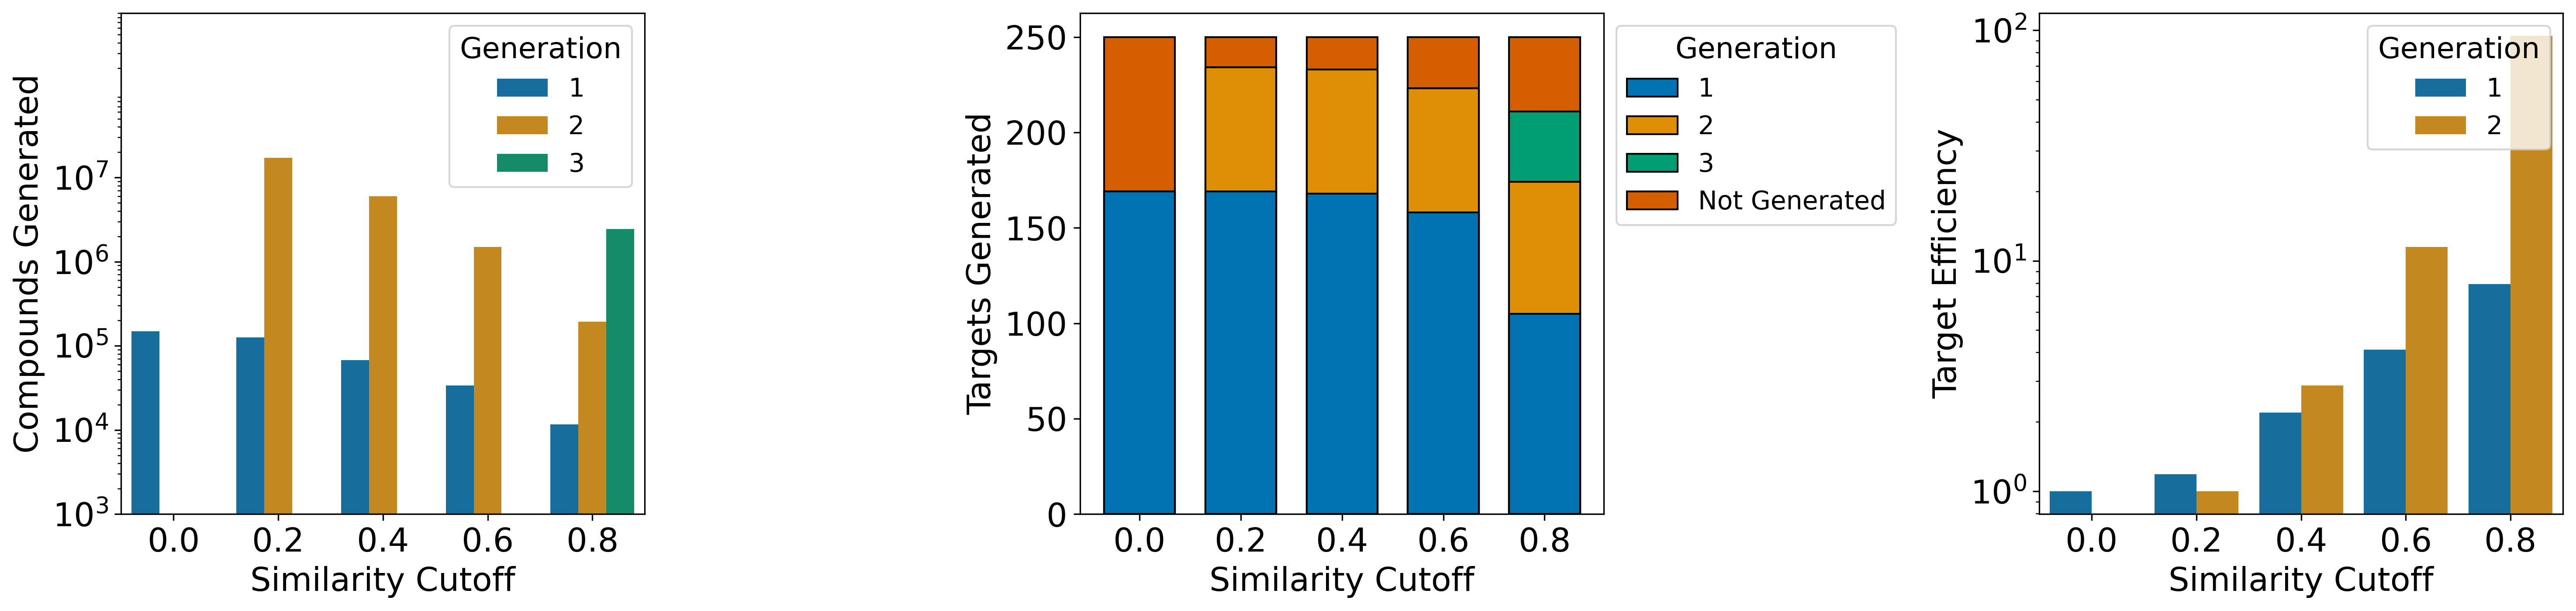

In [102]:
##########################################
# Base plot options
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=300)
fig.subplots_adjust(wspace=0.8)

##########################################
# Some Definitials up front
runs = list(set(compound_df.run))
runs = sorted(runs)
runs = [runs[-1]] + runs[0:-1]

weights = list(set(compound_df.tani))
weights = sorted(weights)

cpd_legends = [str(i) for i in [1, 2, 3]]
target_legends = [str(i) for i in [1, 2, 3]] + ["Not Generated"]

palette = "colorblind"

##########################################
# Plot compound generation plot
ylim = (0, 1000000) 

ax = axs[0]
sns.barplot(
    data=compound_df,
    x="tani", y="counts", hue="generation",
    ax=ax, #palette="dark", alpha=0.6
    palette = palette,
    order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)
ax.set(
    ylabel="Compounds Generated",
    xlabel="Similarity Cutoff",
    ylim=ylim
)


legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    cpd_legends,
    title="Generation"
    )

ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
############################################################
ax = axs[1]
g = sns.histplot(
    data=target_df.sort_values(by=["tani", "generation"]),
    x="tani",
    hue="generation",
    weights="cumsum",
    palette=palette,
    alpha=1,
    shrink=0.7,
    ax=ax,
    # legend=True
    # order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)

ax.set(
    xlabel="Similarity Cutoff",
    ylabel="Targets Generated"
);
# ax.set_xlim(-0.5, 4);

legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    target_legends,
    bbox_to_anchor=(1,1),
    loc="upper left",
    title="Generation",
    )

############################################################
ax = axs[2]
g = sns.barplot(
    ax=ax,
    data=target_df[(target_df["generation"] != "Total Targets") & (target_df["generation"] != 3)].sort_values(by="tani"),
    palette=palette,
    x="tani",
    y="ratio",
    hue="generation"
)

g.set(
    xlabel="Similarity Cutoff",
    ylabel="Target Efficiency",
    yscale="log"
)

for ax in axs[:3]:
    ax.set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
    # ax.ticklabel_format(axis='y', style='sci', scilimits=(5,5))

axs[0].set(
    yscale="log",
    ylim=(0, 9*10E7)
)
axs[0].set_yticks([(10**i) for i in [3, 4, 5, 6, 7]])

axs[1].ticklabel_format(axis='y', style='plain')

axs[0].legend(loc='upper right', title="Generation")
axs[2].legend(loc='upper right', title="Generation")

plt.tight_layout()
############################################################

fig.savefig("../figures/fig4_YMDB_cutoff.png", bbox_inches="tight", facecolor='white')

In [42]:
from matplotlib import rcParams
params = {
   'axes.labelsize': 19,
   'font.size': 19,
   'legend.fontsize': 12,
   'legend.title_fontsize': 14,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
   }
rcParams.update(params)

# sns.set_palette("pastel")

# Quad Plot

<ipython-input-14-f8986dbee2ef>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_df["hrs"] = runtime_df["counts"]/60
<ipython-input-14-f8986dbee2ef>:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1][0].set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")


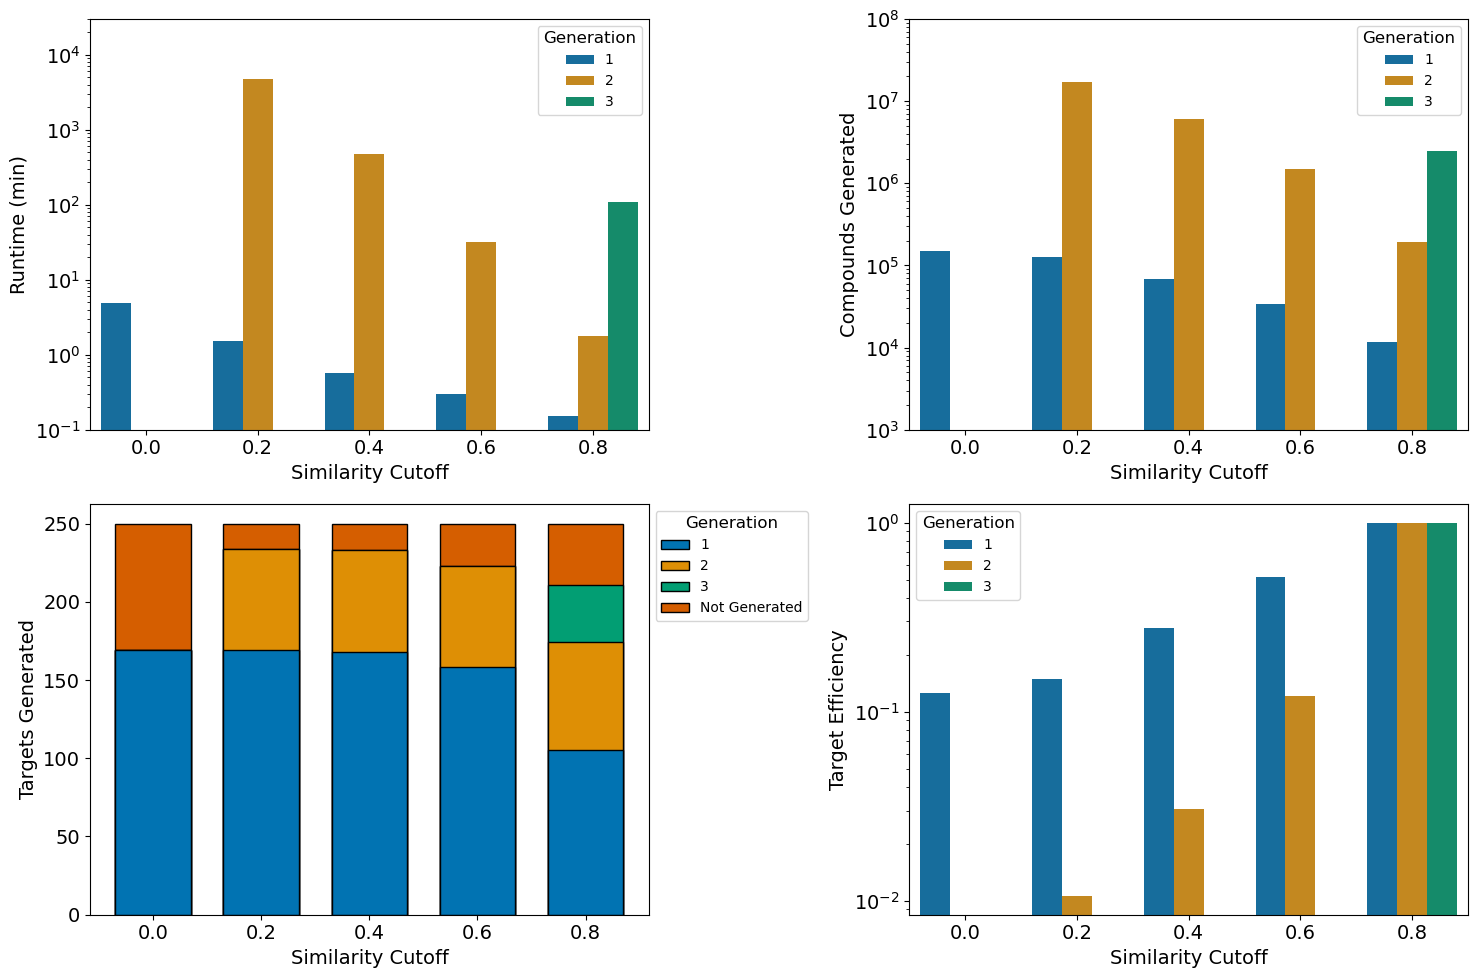

In [14]:
##########################################
# Base plot options
fig, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=100)
fig.subplots_adjust(wspace=0.8)
fig.subplots_adjust(hspace=0.3)

##########################################
# Some Definitials up front
runs = list(set(compound_df.run))
runs = sorted(runs)
runs = [runs[-1]] + runs[0:-1]

weights = list(set(compound_df.tani))
weights = sorted(weights)

cpd_legends = [str(i) for i in [1, 2, 3]]
target_legends = [str(i) for i in [1, 2, 3]] + ["Not Generated"]

palette = "colorblind"

##########################################
# Plot compound generation plot
ylim = (1, 10000) 

ax = axs[0][0]
runtime_df["hrs"] = runtime_df["counts"]/60
sns.barplot(
    data=runtime_df,
    x="tani", y="hrs", hue="generation",
    ax=ax, #palette="dark", alpha=0.6
    palette = palette,
    order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)
ax.set(
    ylabel="Runtime (min)",
    xlabel="Similarity Cutoff",
    ylim=ylim
)


legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    cpd_legends,
    title="Generation"
    )

# ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

##########################################
# Plot compound generation plot
ylim = (0, 10E6) 

ax = axs[0][1]
sns.barplot(
    data=compound_df,
    x="tani", y="counts", hue="generation",
    ax=ax, #palette="dark", alpha=0.6
    palette = palette,
    order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)
ax.set(
    ylabel="Compounds Generated",
    xlabel="Similarity Cutoff",
    ylim=ylim
)


legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    cpd_legends,
    title="Generation"
    )

ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
############################################################
ax = axs[1][0]
g = sns.histplot(
    data=target_df.sort_values(by=["tani", "generation"]),
    x="tani",
    hue="generation",
    weights="cumsum",
    palette=palette,
    alpha=1,
    shrink=0.7,
    ax=ax,
    # legend=True
    # order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)

ax.set(
    xlabel="Similarity Cutoff",
    ylabel="Targets Generated"
);
# ax.set_xlim(-0.5, 4);

legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    target_legends,
    bbox_to_anchor=(1,1),
    loc="upper left",
    title="Generation",
    )

############################################################
ax = axs[1][1]
g = sns.barplot(
    ax=ax,
    data=target_df[(target_df["generation"] != "Total Targets") & (target_df["generation"] != 5)].sort_values(by="tani"),
    palette=palette,
    x="tani",
    y="ratio",
    hue="generation"
)

g.set(
    xlabel="Similarity Cutoff",
    ylabel="Target Efficiency",
    yscale="log"
)

#####
axs[0][1].set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
axs[1][0].set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
axs[1][1].set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
    # ax.ticklabel_format(axis='y', style='sci', scilimits=(5,5))


axs[0][0].set(
    yscale="log",
    ylim=(0.1, 30000)
)
axs[0][1].set(
    yscale="log",
    ylim=(1E3, 10E7)
)
axs[0][1].set_yticks([(10**i) for i in [3, 4, 5, 6, 7, 8]])

axs[1][0].ticklabel_format(axis='y', style='plain')

axs[0][1].legend(loc='upper right', title="Generation")
axs[1][1].legend(loc='upper left', title="Generation")

for i in range(2):
    for j in range(2):
        ax = axs[i][j]
        # x0,x1 = ax.get_xlim()
        # y0,y1 = ax.get_ylim()
        # if (i, j) != (1, 0):
        #     if (i, j) == (0, 0):
        #         y0 = 100
        #     elif (i, j) == (0, 1):
        #         y0, y1 = (1E3, 8*10E7)
        #     y0 = np.log(y0)
        #     y1 = np.log(y1)

        # ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        # print(i, j)
        # ax.set(adjustable='box-forced', aspect='equal')

plt.tight_layout()
############################################################

fig.savefig("../figures/fig4_YMDB_cutoff_quad.png", bbox_inches="tight", facecolor='white', dpi=300)

# Tani crit, but with log target/per generation

TypeError: 'AxesSubplot' object is not subscriptable

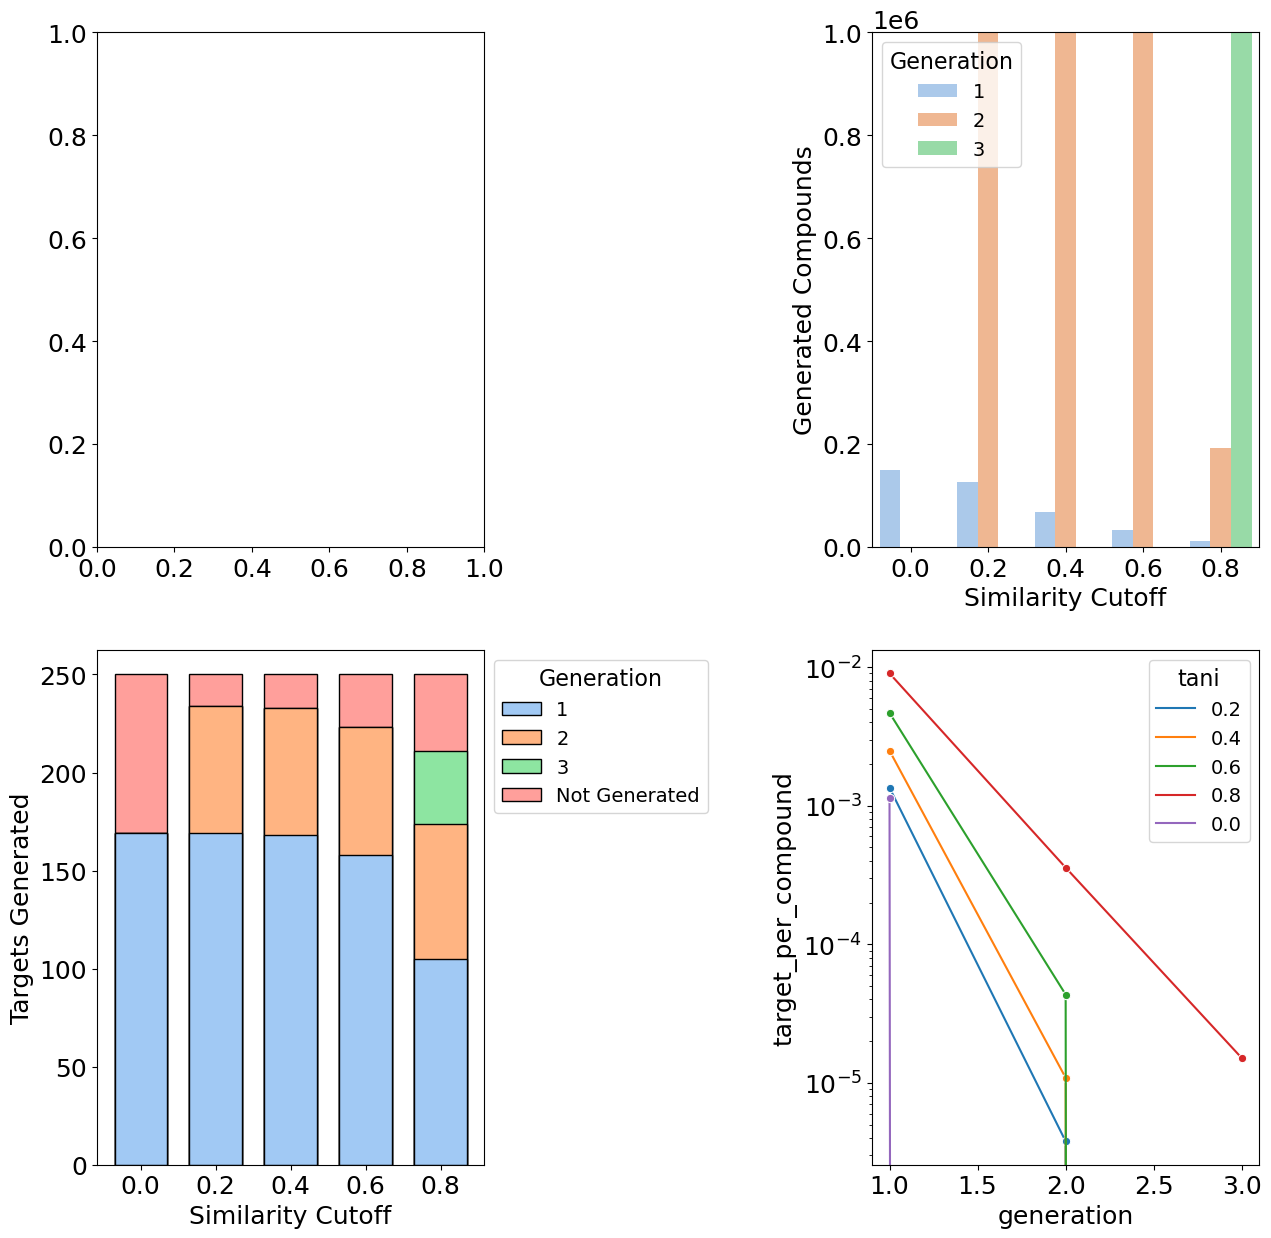

In [59]:
##########################################
# Base plot options
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=100)
fig.subplots_adjust(wspace=1)

##########################################
# Some Definitials up front
runs = list(set(compound_df.run))
runs = sorted(runs)
runs = [runs[-1]] + runs[0:-1]

weights = list(set(compound_df.tani))
weights = sorted(weights)

palette = "pastel"

cpd_legends = [str(i) for i in [1, 2, 3]]
target_legends = [str(i) for i in [1, 2, 3]] + ["Not Generated"]


##########################################
# Plot compound generation plot
ylim = (0, 1000000) 

ax = axs[0][1]
sns.barplot(
    data=compound_df,
    x="tani", y="counts", hue="generation",
    ax=ax, #palette="dark", alpha=0.6
    palette=palette,
    order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)
ax.set(
    ylabel="Generated Compounds",
    xlabel="Similarity Cutoff",
    ylim=ylim
)

legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    cpd_legends,
    title="Generation"
    )

ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
############################################################
ax = axs[1][0]
g = sns.histplot(
    data=target_df.sort_values(by=["tani", "generation"]),
    x="tani",
    hue="generation",
    weights="cumsum",
    palette=palette,
    alpha=1,
    shrink=0.7,
    ax=ax,
    # legend=True
    # order=["0.0", "0.2", "0.4", "0.6", "0.8"]
)

ax.set(
    xlabel="Similarity Cutoff",
    ylabel="Targets Generated"
);
# ax.set_xlim(-0.5, 4);

legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    target_legends,
    bbox_to_anchor=(1,1),
    loc="upper left",
    title="Generation",
    )

############################################################
ax = axs[1][1]
g = sns.lineplot(
    ax=ax,
    data=target_df[target_df["generation"] != "Total Targets"],
    x="generation",
    y="target_per_compound",
    hue="tani",
    marker='o'
)
g.set(yscale="log")



axs[0][1].set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
ax[0][1].ticklabel_format(axis='y', style='sci', scilimits=(5,5))
axs[0][2].set_xticklabels(weights)#, rotation=60, ha='right', rotation_mode="anchor")
ax[0][2].ticklabel_format(axis='y', style='sci', scilimits=(5,5))

axs[0][1].set(
    yscale="log",
    ylim=(0, 4*10**7)
)
axs[0][1].set_yticks([(10**i) for i in [3, 4, 5, 6, 7]])
############################################################

In [18]:
target_df

,run,generation,tani,num,type,counts,cumsum,target_per_compound,ratio
0,kms_YMDB_cutoff_0.2t,1,0.2,0.2,targets,169.0,169,0.001347,1.184930
1,kms_YMDB_cutoff_0.2t,2,0.2,0.2,targets,65.0,234,0.000004,1.000000
2,kms_YMDB_cutoff_0.2t,3,0.2,0.2,targets,0.0,234,0.000000,NaN
3,kms_YMDB_cutoff_0.4t,1,0.4,0.4,targets,168.0,168,0.002493,2.193333
4,kms_YMDB_cutoff_0.4t,2,0.4,0.4,targets,65.0,233,0.000011,2.874060
5,kms_YMDB_cutoff_0.4t,3,0.4,0.4,targets,0.0,233,0.000000,NaN
6,kms_YMDB_cutoff_0.6t,1,0.6,0.6,targets,158.0,158,0.004673,4.112194
7,kms_YMDB_cutoff_0.6t,2,0.6,0.6,targets,65.0,223,0.000043,11.465592
8,kms_YMDB_cutoff_0.6t,3,0.6,0.6,targets,0.0,223,0.000000,NaN
9,kms_YMDB_cutoff_0.8t,1,0.8,0.8,targets,105.0,105,0.009014,7.931839


In [19]:
target_df.sort_values(by=["tani", "generation"])

,run,generation,tani,num,type,counts,cumsum,target_per_compound,ratio
12,kms_YMDB_cutoff_0.0t,1,0.0,0.0,targets,169.0,169,0.001136,1.000000
13,kms_YMDB_cutoff_0.0t,2,0.0,0.0,targets,0.0,169,0.000000,0.000000
14,kms_YMDB_cutoff_0.0t,3,0.0,0.0,targets,0.0,169,0.000000,NaN
17,0,Total Targets,0.0,<class 'float'>,0,0.0,250,0.000000,NaN
0,kms_YMDB_cutoff_0.2t,1,0.2,0.2,targets,169.0,169,0.001347,1.184930
1,kms_YMDB_cutoff_0.2t,2,0.2,0.2,targets,65.0,234,0.000004,1.000000
2,kms_YMDB_cutoff_0.2t,3,0.2,0.2,targets,0.0,234,0.000000,NaN
19,0,Total Targets,0.2,<class 'float'>,0,0.0,250,0.000011,NaN
3,kms_YMDB_cutoff_0.4t,1,0.4,0.4,targets,168.0,168,0.002493,2.193333
4,kms_YMDB_cutoff_0.4t,2,0.4,0.4,targets,65.0,233,0.000011,2.874060


## Plot targets and compounds

In [20]:
%%capture
compound_df = tani_melt_df[(tani_melt_df["type"] == "compounds") & (tani_melt_df["generation"] != "total")]
target_df = tani_melt_df[(tani_melt_df["type"] == "targets") & (tani_melt_df["generation"] != "total")]

w_dfs = []
weights = set(target_df.tani)
for weight in weights:
    w_dfs.append(target_df[target_df["tani"] == weight]["counts"].cumsum())

cumsum_df = pd.concat(w_dfs)
target_df.loc[cumsum_df.index, "cumsum"] = cumsum_df

target_df = target_df.append(total_targets)

target_df.tani = target_df.tani.map(lambda s: float(s))
compound_df.tani = compound_df.tani.map(lambda s: float(s))

target_df = target_df.append(pd.DataFrame([{"tani": 1, "type": "targets", "counts": 0, "generation": 1}]))

compound_df = compound_df.append(pd.DataFrame([{"tani": 1, "counts": 0, "generation": 1}]))

In [21]:
cpd_trgt = compound_df.merge(target_df, on=["run", "generation"])
target_df["target_per_compound"] = cpd_trgt["counts_y"]/cpd_trgt["counts_x"]

target_df = target_df.fillna(0)
target_df.reset_index(drop=True, inplace=True)

w_dfs = []
weights = set(target_df.tani)
for weight in weights:
    w_dfs.append(target_df[target_df["tani"] == weight]["target_per_compound"].cumsum())

cumsum_df = pd.concat(w_dfs)
target_df.loc[cumsum_df.index, "target_per_compound_cumsum"] = cumsum_df

target_df


,run,generation,tani,num,type,counts,cumsum,target_per_compound,target_per_compound_cumsum
0,kms_YMDB_cutoff_0.2t,1,0.2,0.2,targets,169.0,169.0,0.001347,0.001347
1,kms_YMDB_cutoff_0.2t,2,0.2,0.2,targets,65.0,234.0,0.000004,0.001350
2,kms_YMDB_cutoff_0.2t,3,0.2,0.2,targets,0.0,234.0,0.000000,0.001350
3,kms_YMDB_cutoff_0.4t,1,0.4,0.4,targets,168.0,168.0,0.002493,0.002493
4,kms_YMDB_cutoff_0.4t,2,0.4,0.4,targets,65.0,233.0,0.000011,0.002504
5,kms_YMDB_cutoff_0.4t,3,0.4,0.4,targets,0.0,233.0,0.000000,0.002504
6,kms_YMDB_cutoff_0.6t,1,0.6,0.6,targets,158.0,158.0,0.004673,0.004673
7,kms_YMDB_cutoff_0.6t,2,0.6,0.6,targets,65.0,223.0,0.000043,0.004717
8,kms_YMDB_cutoff_0.6t,3,0.6,0.6,targets,0.0,223.0,0.000000,0.004717
9,kms_YMDB_cutoff_0.8t,1,0.8,0.8,targets,105.0,105.0,0.009014,0.009014


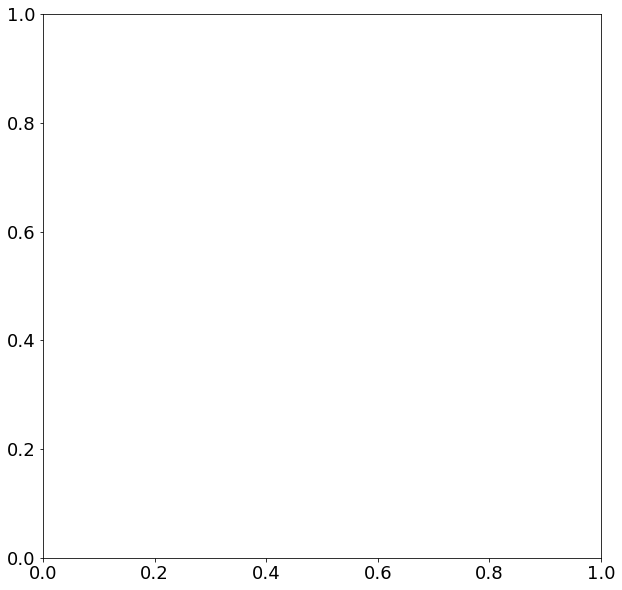

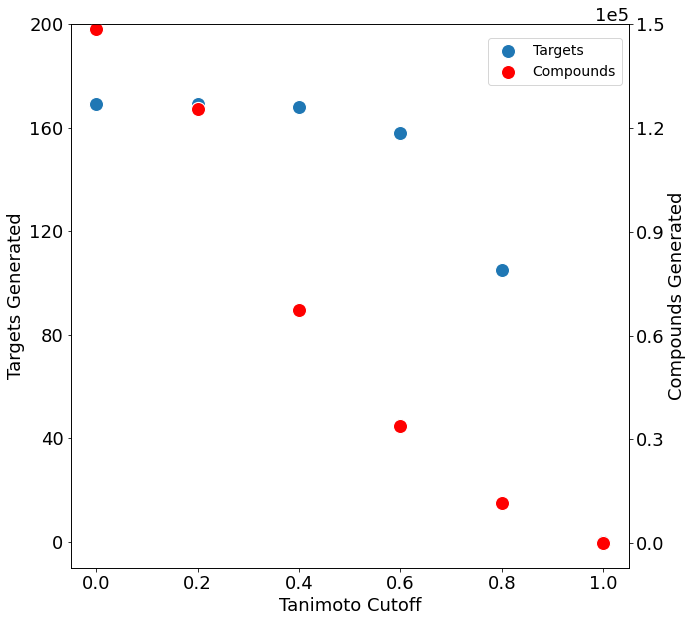

In [22]:
##########################################
# Base plot options
fig, ax1 = plt.subplots(figsize=(10, 10))

##########################################
# Some Definitials up front
legends = ["Targets", "Compounds"]

target_val_df = target_df[target_df["generation"] == 1]
compound_val_df = compound_df[compound_df["generation"] == 1]

markers = True
s = 200

minlim1 = -10
maxlim1 = 200

ax2_log = False
maxlim2 = 1.5*10**5
minlim2 = minlim1/(maxlim1-minlim1)*maxlim2

##########################################

fig, ax1 = plt.subplots(figsize=(10, 10)) # initializes figure and plots
ax2 = ax1.twinx()


g1 = sns.scatterplot(
    data=target_val_df,
    x="tani",
    y="counts",
    ax=ax1,
    label="Targets",
    legend=False,
    markers=markers,
    s=s
)

g2 = sns.scatterplot(
    data=compound_val_df,
    x="tani", 
    y="counts", 
    ax=ax2,
    label="Compounds", 
    legend=False,
    color="red", 
    markers=markers, 
    s=s
)

#####
# Target Formatting
ax1.set(
    ylim=(minlim1, maxlim1),
    ylabel="Targets Generated",
    xlabel="Tanimoto Cutoff"
)

#####
# Compound Formatting
ax2.set(ylim=(minlim2, maxlim2),
        ylabel="Compounds Generated",
        yscale="log" if ax2_log else "linear",
)

#####
# Label
labs = [l.get_label() for l in [g1, g2]]
ax1.figure.legend(bbox_to_anchor=(0.5, 0., 0.4, 0.87))

#####
# X formatting
ax1.set(xlim=(-0.05, 1.05))
ax1.set_yticks(np.linspace(0, maxlim1, 6))
# max2 = np.nanmax(ax2.get_ybound())
ax2_ticks = [(10**i) for i in range(8)] if ax2_log else np.linspace(0, maxlim2, 6)
ax2.set_yticks(ax2_ticks)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(5,5))

<AxesSubplot:xlabel='generation', ylabel='target_per_compound'>

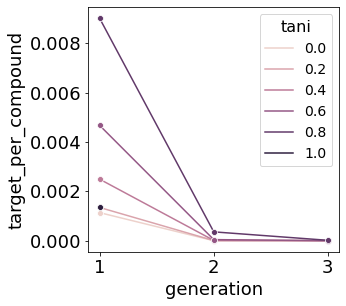

In [23]:
sns.lineplot(data=target_df[target_df["generation"] != "Total Targets"], x="generation", y="target_per_compound", hue="tani", marker='o')

In [24]:
target_df

,run,generation,tani,num,type,counts,cumsum,target_per_compound,target_per_compound_cumsum
0,kms_YMDB_cutoff_0.2t,1,0.2,0.2,targets,169.0,169.0,0.001347,0.001347
1,kms_YMDB_cutoff_0.2t,2,0.2,0.2,targets,65.0,234.0,0.000004,0.001350
2,kms_YMDB_cutoff_0.2t,3,0.2,0.2,targets,0.0,234.0,0.000000,0.001350
3,kms_YMDB_cutoff_0.4t,1,0.4,0.4,targets,168.0,168.0,0.002493,0.002493
4,kms_YMDB_cutoff_0.4t,2,0.4,0.4,targets,65.0,233.0,0.000011,0.002504
5,kms_YMDB_cutoff_0.4t,3,0.4,0.4,targets,0.0,233.0,0.000000,0.002504
6,kms_YMDB_cutoff_0.6t,1,0.6,0.6,targets,158.0,158.0,0.004673,0.004673
7,kms_YMDB_cutoff_0.6t,2,0.6,0.6,targets,65.0,223.0,0.000043,0.004717
8,kms_YMDB_cutoff_0.6t,3,0.6,0.6,targets,0.0,223.0,0.000000,0.004717
9,kms_YMDB_cutoff_0.8t,1,0.8,0.8,targets,105.0,105.0,0.009014,0.009014
